In [1]:
import collections
import itertools
import os

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize

import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format='retina'
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath,amssymb}',
})

import dclf

from tqdm.auto import tqdm

tracker = dclf.ParamTracker()
param = tracker.store


Figure saved as ./output/min_pay_qualitative_comparison.pdf


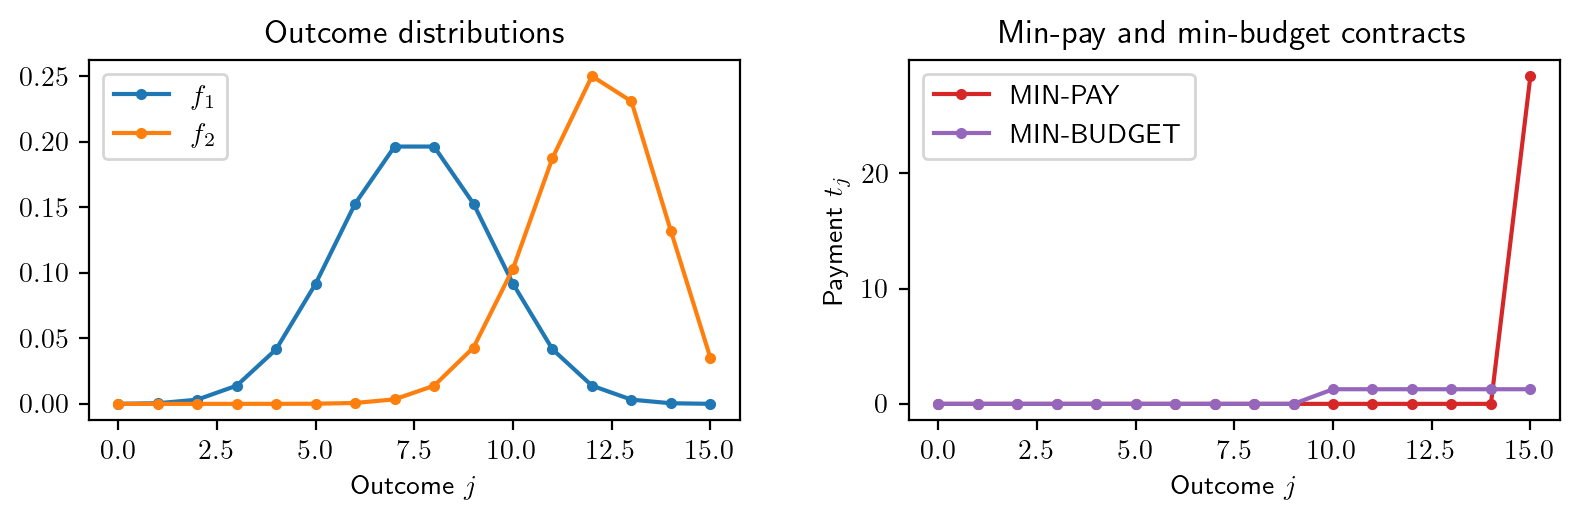

In [2]:
m = param(15,'m')
p_vec = [
    param(0.5,'p_low'),
    param(0.8,'p_high'),
]
f_ij = np.array([
    stats.binom.pmf(np.arange(m+1),m,p_vec[0]),
    stats.binom.pmf(np.arange(m+1),m,p_vec[1]),
])
cost = [0,1]
cdp = dclf.ContractDesignProblem(f_ij, cost)

mp = dclf.MinPayContract.design(cdp)
mb = dclf.MinBudgetContract.design(cdp)

fig,axs = plt.subplots(1,2,figsize=(8,2.7),tight_layout={'w_pad':3})
axs_it = iter(axs.ravel())

ax = next(axs_it)
ax.plot(f_ij.T,marker='.')
ax.legend([f'$f_{{ {i+1} }}$' for i in range(2)])
ax.set(
    title='Outcome distributions',
    xlabel='Outcome $j$',
)


ax = next(axs_it)
ax.plot(
    mp['t'],
    color='tab:red',
    marker='.',
    label='MIN-PAY',
)
ax.plot(
    mb['t'],
    color='tab:purple',
    marker='.',
    label='MIN-BUDGET',
)
ax.legend()
ax.set(
    title='Min-pay and min-budget contracts',
    xlabel='Outcome $j$',
    ylabel='Payment $t_j$',
)

dclf.save_and_download_fig(fig, './output/min_pay_qualitative_comparison.pdf')

In [3]:
m_vec = np.arange(3,50,3)
results = []

contracts = {
    'MIN-PAY': dclf.MinPayContract.design,
    'MIN-BUDGET': dclf.MinBudgetContract.design,
}

for m in tqdm(m_vec):
    f_ij = np.array([
        stats.binom.pmf(np.arange(m+1),m,p_vec[0]),
        stats.binom.pmf(np.arange(m+1),m,p_vec[1]),
    ])
    cdp = dclf.ContractDesignProblem(f_ij, cost)
    for c_name, c_func in contracts.items():
        t = c_func(cdp)['t']
        results.append({
            'm':m,
            'contract_type': c_name,
            't': t,
            'B': t.max(),
            'p': f_ij[-1]@(t>=1e-6),
            'exp': f_ij[-1]@t,
        })
        

results_df = pd.DataFrame(results)
results_df.head()

  0%|          | 0/16 [00:00<?, ?it/s]

,m,contract_type,t,B,p,exp
0,3,MIN-PAY,"[0.0, 0.0, 0.0, 2.58397932816537]",2.583979,0.512000,1.322997
1,3,MIN-BUDGET,"[0.0, 0.0, 2.52525252525253, 2.52525252525253]",2.525253,0.896000,2.262626
2,6,MIN-PAY,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.05648246179808]",4.056482,0.262144,1.063383
3,6,MIN-BUDGET,"[0.0, 0.0, 0.0, 0.0, 1.79414033765721, 1.79414...",1.794140,0.901120,1.616736
4,9,MIN-PAY,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.560602,0.134218,1.014767


Figure saved as ./output/min_pay_comparison_as_a_function_m.pdf


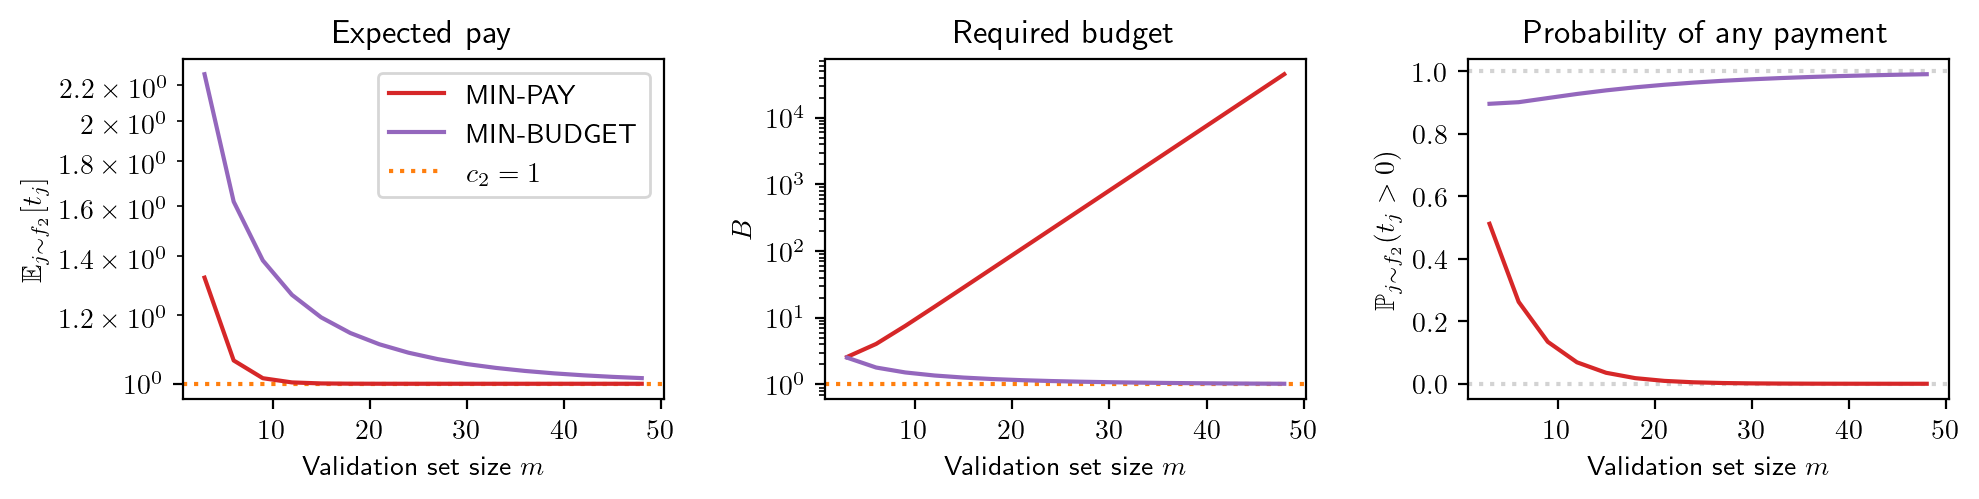

In [9]:
fig,axs = plt.subplots(1,3,figsize=(10,2.6),tight_layout={'w_pad':2})
axs_it = iter(axs.ravel())
columns = {
    'exp': ('Expected pay', '$\\mathbb{E}_{j \\sim f_2}[t_j]$'),
    'B': ('Required budget','$B$'),
    'p': ('Probability of any payment','$\\mathbb{P}_{j \\sim f_2}(t_j > 0)$'),
}

for i,(col,ax) in enumerate(zip(columns, axs_it)):
    (
        results_df.pivot(
            index='m',
            columns='contract_type',
            values=col,
        )
        [list(contracts)]
        .plot.line(
            ax=ax,
            title=columns[col][0],
            color=['tab:red','tab:purple'],
        )
    )
    ax.get_legend().remove()
    ax.set(
        xlabel='Validation set size $m$',
        ylabel=columns[col][1],
    )
    if col=='p':
        ax.axhline(1,**dclf.background_line_style)
        ax.axhline(0,**dclf.background_line_style)
    elif col=='B' or col=='exp':
        ax.set_yscale('log')
        ax.axhline(1,linestyle=':',color='tab:orange',zorder=-1,label=f'$c_2={cost[-1]:g}$')
    if i==0:
        ax.legend()

dclf.save_and_download_fig(fig, './output/min_pay_comparison_as_a_function_m.pdf')

In [5]:
tracker.save('./output/min_pay.json')